In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
from helpers import *

Using TensorFlow backend.


Initialized TensorFlow


### Steps:
1. Train $M$ networks for each dropout on training $p\in[0,1]$
2. Get mean MAE on test/train for crash/nocrash. How does it behave? **Read papers where Dropout actually works for simple datasets. Do they use scaled or unscaled dropout?**
3. Get v1, v2, v3, v4 for each of the networks
4. Compute the rank loss if the networks were ordered by these bounds
5. What should be the batch size? Does keras update crashes at each iteration?

Currently, the problem is at the 2nd stage: I cannot make a network more MAE-resilient towards crashes on the Boston dataset. MNIST shows promising results if I use a smaller p_train than p_inference and batch size 100. Should I make it less? Should I make it bigger? How do I test it? Should I look at the tensorflow graph? Or should I read keras documentation?

Keras Dropout calls K.dropout which calls tf.nn.dropout, which by default creates a noise equal to the argument in shape, meaning that for 10 objects it will create 10 random dropout configurations

OK, it works for MNIST but doesn't work for the Boston dataset. Let's forget about the Boston dataset.

NEXT STEP: re-test it on bigger p, then go to steps 3, 4, 5 etc. Works for p < pinference, worse after

In [2]:
# network configuration
N = [100, 50]

def get_p_arr(p):
    """ p array with failure on the first layer """
    return [0, p]  + [0] * len(N)

# prob. of failure at inference
p_inf = 0.05
p_inference = get_p_arr(p_inf)

# prob. of failure at train
p_trains = np.linspace(0, 1.2 * p_inf, 10)

# Lips. coeff
KLips = 1.

# activation function
activation = 'sigmoid'

# number of repeats for error estimation
# see below for explanation
repetitions = 6

# number of runs for each p
runs = 10

In [3]:
def get_results(p):
    # obtaining the distribution after 10 epochs
    results = []
    
    # current prob. of failure array
    p_train = get_p_arr(p)
    
    def unravel(name, data):
        return {name + '_' + key: data[key] for key in data.keys()}
    
    for _ in tqdm(range(runs)):
        exp = MNISTExperiment(N = N, p_inference = p_inference, p_train = p_train, KLips = KLips, epochs = 10,
                                      activation = activation, reg_type = None, reg_coeff = 0, do_print = False,
                                      name = 'experiment_dropout', seed = None, batch_size = 100)
        
        results += [{**unravel('correct_acc', exp.get_accuracy_correct()), # test_only = True
                     **unravel('crashing_acc', exp.get_accuracy_crash(repetitions = repetitions)), # test_only = True
                     
                     **unravel('correct_mae', exp.get_mae_correct()),
                     **unravel('crashing_mae', exp.get_mae_crash(repetitions = repetitions)),
                     
                     'v2_var': np.mean(exp.get_bound_v2(exp.x_train)['std'] ** 2),
                     'v2_mean': np.mean(exp.get_bound_v2(exp.x_train)['mean']),
                     
                     'v3_var': np.mean(exp.get_bound_v3(exp.x_train)['std'] ** 2),
                     'v3_mean': np.mean(exp.get_bound_v3(exp.x_train)['mean']),
                               
                     'v4_var': np.mean(exp.get_bound_v4(exp.x_train)['std'] ** 2),
                     'v4_mean': np.mean(exp.get_bound_v4(exp.x_train)['mean']),
                    }]
        
        # freeing up the memory
        K.clear_session()
        
    # list of all keys
    keys = list(results[0].keys())
    
    # return results
    return {key: [value[key] for value in results] for key in keys}

def process_results_single(results):
    for key, value in results.items():
        plt.figure()
        plt.title('%s: %.3f +- %.3f med %.3f' % (key, np.mean(value), np.std(value), np.median(value)))
        plt.hist(value)
        plt.xlabel(key)
        plt.show()

In [4]:
exp = MNISTExperiment(N = N, p_inference = p_inference, p_train = get_p_arr(0.01), KLips = KLips, epochs = 10,
                                      activation = activation, reg_type = None, reg_coeff = 0, do_print = False,
                                      name = 'experiment_dropout', seed = None, batch_size = 100)

In [5]:
# array of repetitions values
rs = np.arange(10)[1:]

In [6]:
# obtaining accuracy for each repetition parameter
results = [exp.get_accuracy_crash(repetitions = r) for r in tqdm(rs)]

100%|██████████| 9/9 [00:37<00:00,  5.60s/it]


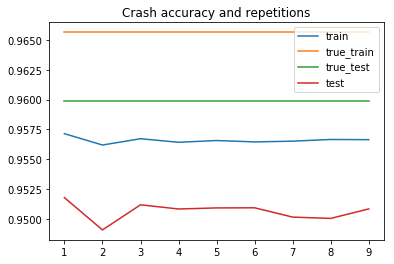

In [10]:
plt.figure()
plt.title('Crash accuracy and repetitions')
plt.plot(rs, [x['train'] for x in results], label = 'train')
plt.plot(rs, [exp.get_accuracy_correct()['train']] * len(rs), label = 'true_train')
plt.plot(rs, [exp.get_accuracy_correct()['test']] * len(rs), label = 'true_test')
plt.plot(rs, [x['test'] for x in results], label = 'test')
plt.legend()
plt.show()

In [11]:
# obtaining accuracy for each repetition parameter
results = [exp.get_mae_crash(repetitions = r) for r in tqdm(rs)]

100%|██████████| 9/9 [00:35<00:00,  5.17s/it]


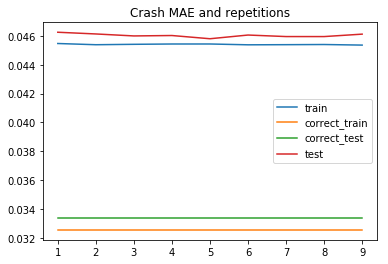

In [14]:
plt.figure()
plt.title('Crash MAE and repetitions')
plt.plot(rs, [x['train'] for x in results], label = 'train')
plt.plot(rs, [exp.get_mae_correct()['train']] * len(rs), label = 'correct_train')
plt.plot(rs, [exp.get_mae_correct()['test']] * len(rs), label = 'correct_test')
plt.plot(rs, [x['test'] for x in results], label = 'test')
plt.legend()
plt.show()

In [4]:
# 6 repetitions of the dataset is enough

In [4]:
# obtaining results
results_array = [get_results(p) for p in p_trains]

100%|██████████| 10/10 [04:29<00:00, 27.31s/it]


In [7]:
#pickle.dump(results_array, open('ComparisonIncreasingDropoutMNIST.ipynb.py', 'wb'))

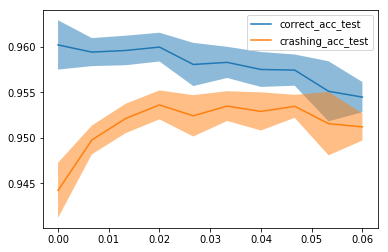

In [6]:
plt.figure()

def plot_quantity(results_array, name):
    means = np.array([np.mean(r[name]) for r in results_array])
    stds  = [np.std(r[name]) for r in results_array]
    plt.plot(p_trains, means, label = name)
    plt.fill_between(p_trains, means - stds, means + stds, alpha = 0.5)

plot_quantity(results_array, 'correct_acc_test')
plot_quantity(results_array, 'crashing_acc_test')
plt.legend()